# Demonstration of variational inference of discrete HMMs with Categorical or Independent Bernoulli emissions
Based on Matthew Beal's thesis (2003)
https://cse.buffalo.edu/faculty/mbeal/thesis/

In [1]:
# Import stuff
import numpy as np
import DiscreteHMM
import variationalHMM
from hinton import hinton

%matplotlib inline
import pylab as plt

# Categorical emissions

In [57]:
# Make some categorical data. 2 sequences of data with 3 emissions (0, 1, or 2). 2 states in the data, with the 
# states switching at 100 and 200 on both sequences
# Emission probabilities on state 0 - [1/3, 1/3, 1/3]
# Emission probabilities on state 1 - [1/6, 2/3, 1/6]
data = np.zeros((2,300))
data[0, :100] = np.random.choice(np.arange(3), size = 100, p = [1/3, 1/3, 1/3])
data[0, 100:200] = np.random.choice(np.arange(3), size = 100, p =  [1/6, 2/3, 1/6])
data[0, 200:] = np.random.choice(np.arange(3), size = 100, p = [1/3, 1/3, 1/3])
data[1, :100] = np.random.choice(np.arange(3), size = 100, p =  [1/3, 1/3, 1/3])
data[1, 100:200] = np.random.choice(np.arange(3), size = 100, p =  [1/6, 2/3, 1/6])
data[1, 200:] = np.random.choice(np.arange(3), size = 100, p =  [1/3, 1/3, 1/3])

We will train HMMs with more than 2 states. MAP/MLE estimation will naturally overfit with these additional parameters. We will demonstrate that keeping track of the entire posterior distribution over the parameters (through variational inference) naturally picks out the right number of states. We will follow the lead in Beal (2003) and first train a model with MAP on the data. We will then use the parameters picked out by this model as starting guesses for the variational posteriors. We will use the variational EM algorithm to optimize these posteriors, while optimizing their hyperparameters to maximize the marginal likelihood of the data (in an empirical Bayes' strategy).

In [58]:
# MAP model
model_MAP = DiscreteHMM.CategoricalHMM(num_states = 5, num_emissions = 3, max_iter = 1000, threshold = 1e-4)

In [59]:
# Fit with very weak priors. Just 1 pseudocount, probably ok for start probabilities, but likely more pseudocounts
# needed for the transition and emission probabilities
model_MAP.fit(data=data, p_transitions=np.random.random(size=(5, 5)), p_emissions=np.random.random(size=(5, 3)), 
          p_start=np.random.random(5), transition_pseudocounts=np.ones((5, 5)), emission_pseudocounts=np.ones((5, 3)), 
          start_pseudocounts=np.ones(5), verbose = False)

In [60]:
model_MAP.converged

True

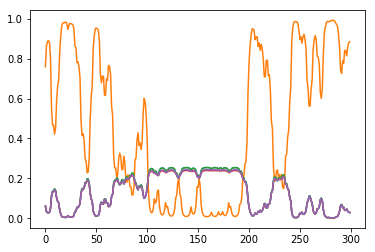

In [61]:
# Get the posterior probabilities of the states from the E step
alpha, beta, scaling, expected_latent_state, expected_latent_state_pair = model_MAP.E_step()
plt.plot(expected_latent_state[:, 0, :].T)

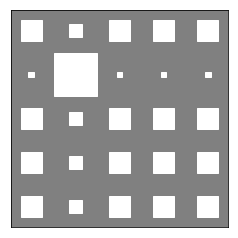

In [62]:
hinton(model_MAP.p_transitions.T)

Very clearly, the model is using all 5 states, and is overfitting the data badly! Let's try variational inference with the parameters found by this MAP fit.

In [63]:
# variational model
model_VI = variationalHMM.CategoricalHMM(num_states = 5, num_emissions = 3, max_iter = 1000, threshold = 1e-4)

In [64]:
# Fit with hyperpriors = 10 on the transition and emission parameters and 1 on the start parameters. Use the 
# parameters from the MAP fit as initial posterior guesses
model_VI.fit(data = data, transition_hyperprior = 1, emission_hyperprior = 1, start_hyperprior = 1, 
          initial_transition_counts = 30*np.random.random()*model_MAP.p_transitions, \
             initial_emission_counts = 30*np.random.random()*model_MAP.p_emissions,
            initial_start_counts = 2*np.random.random()*model_MAP.p_start, 
             update_hyperpriors = True, update_hyperpriors_iter = 1,
            verbose = False)

/media/glia/code_projects/PyHMM/PyHMM/variationalHMM.py:25: RuntimeWarning: invalid value encountered in add
  + np.sum((a - b) * (digamma(a) - digamma(np.sum(a, axis = 1, keepdims = True))), axis = 1, keepdims = True)


In [65]:
model_VI.converged

True

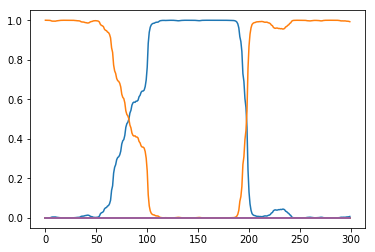

In [66]:
# Get the posterior probabilities of the states from the E step
# With VI, these posterior probabilities are averaged with the whole variational posterior of the parameters (and
# not calculated on the basis of a single parameter value)
alpha, beta, scaling, expected_latent_state, expected_latent_state_pair = model_VI.E_step()
plt.plot(expected_latent_state[:, 0, :].T)

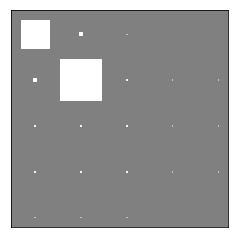

In [67]:
hinton(model_VI.transition_counts.T)

In [68]:
model_VI.emission_counts/np.sum(model_VI.emission_counts, axis = 1, keepdims = True)

array([[ 0.13337974,  0.69732036,  0.1692999 ],
       [ 0.36572178,  0.32005355,  0.31422467],
       [ 0.33333333,  0.33333333,  0.33333333],
       [ 0.33333333,  0.33333333,  0.33333333],
       [ 0.33333333,  0.33333333,  0.33333333]])

Very clearly, the variational solution picks the right number of states (2) to use to model the data (state 1 and 2 here), and finds the right emission probabilities for them

In [70]:
model_VI.ELBO[-1]

-633.60048438406886

# Independent Bernoulli emissions

In [71]:
# Make some Bernoulli data. 2 sequences of data with 3 independent Bernoulli emissions. 2 states in the data, with the 
# states switching at 100 and 200 on both sequences
# Probability of emitting 1 on state 0 - [1/3, 1/3, 1/3]
# Probability of emitting 1 on state 1 - [1/6, 2/3, 1/6]
data = np.zeros((3, 2, 300)) 
p = np.array([[1/3, 1/3, 1/3], [1/6, 2/3, 1/6]])
# state 0 runs from 0-100
for i in range(2):                                           
    for j in range(100):                                              
        for k in range(3):                                            
            data[k, i, j] = np.random.binomial(1, p[0, k])
# state 1 runs from 100-200
for i in range(2):                                           
    for j in range(100):                                              
        for k in range(3):                                            
            data[k, i, j+100] = np.random.binomial(1, p[1, k])
# state 0 runs from 200-300
for i in range(2):                                           
    for j in range(100):                                              
        for k in range(3):                                            
            data[k, i, j+200] = np.random.binomial(1, p[0, k])

In [72]:
# MAP model
model_MAP = DiscreteHMM.IndependentBernoulliHMM(num_states = 5, num_emissions = 3, max_iter = 1000, threshold = 1e-4)

In [73]:
# Fit with very weak priors. Just 1 pseudocount, probably ok for start probabilities, but likely more pseudocounts
# needed for the transition and emission probabilities
model_MAP.fit(data=data, p_transitions=np.random.random(size=(5, 5)), p_emissions=np.random.random(size=(5, 3)), 
          p_start=np.random.random(5), transition_pseudocounts=np.ones((5, 5)), emission_pseudocounts=np.ones((5, 3, 2)), 
          start_pseudocounts=np.ones(5), verbose = False)

In [74]:
model_MAP.converged

True

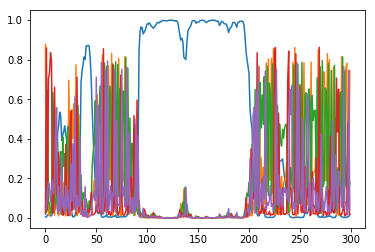

In [75]:
# Get the posterior probabilities of the states from the E step
alpha, beta, scaling, expected_latent_state, expected_latent_state_pair = model_MAP.E_step()
plt.plot(expected_latent_state[:, 0, :].T)

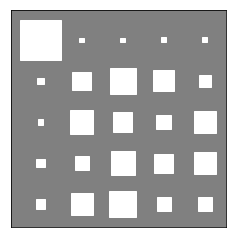

In [76]:
hinton(model_MAP.p_transitions.T)

Again, the MAP model is using all 5 states to overfit the data. Let's try variational inference

In [77]:
# variational model
model_VI = variationalHMM.IndependentBernoulliHMM(num_states = 5, num_emissions = 3, max_iter = 1000, threshold = 1e-4)

In [78]:
# Fit with hyperpriors = 10 on the transition and emission parameters and 1 on the start parameters. Use the 
# parameters from the MAP fit as initial posterior guesses
# First convert the emission probabilities from the MAP model to bernoulli probabilities
p_emissions_bernoulli = np.zeros((model_VI.num_states, model_VI.num_emissions, 2))
p_emissions_bernoulli[:, :, 0] = model_MAP.p_emissions
p_emissions_bernoulli[:, :, 1] = 1.0 - model_MAP.p_emissions

model_VI.fit(data = data, transition_hyperprior = 1, emission_hyperprior = 1, start_hyperprior = 1, 
          initial_transition_counts = 30*model_MAP.p_transitions, initial_emission_counts = 30*p_emissions_bernoulli,
            initial_start_counts = 2*model_MAP.p_start, update_hyperpriors = True, update_hyperpriors_iter = 1,
            verbose = False)

/media/glia/code_projects/PyHMM/PyHMM/variationalHMM.py:25: RuntimeWarning: invalid value encountered in add
  + np.sum((a - b) * (digamma(a) - digamma(np.sum(a, axis = 1, keepdims = True))), axis = 1, keepdims = True)


In [79]:
model_VI.converged

True

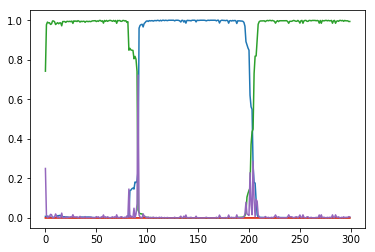

In [80]:
# Get the posterior probabilities of the states from the E step
alpha, beta, scaling, expected_latent_state, expected_latent_state_pair = model_VI.E_step()
plt.plot(expected_latent_state[:, 0, :].T)

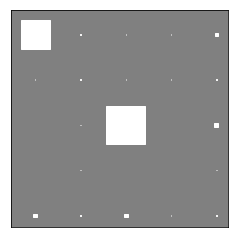

In [83]:
hinton(model_VI.transition_counts)

In [82]:
model_VI.ELBO[-1]

-1108.6827248170755

Again, VI picks the right number of states (2). Keep in mind that there are multiple local maxima in ELBO, and VI
can get stuck there (as with MLE or MAP). So, multiple initializations are a key (I had to do several initializations to get the results shown here)